In [2]:
# sensor fusion 
# sean chang 2016

#https://github.com/morgil/madgwick_py/blob/master/quaternion.py
#https://github.com/micropython-IMU/micropython-fusion

<a id='top'>
[PSD](#PSD)

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
sns.set(style="darkgrid")
import os 


import os
import argparse
import logging
import json
import ds_commons.s3_tools as s3
from datetime import datetime
import requests

import gzip
os.chdir('/Users/schang/Dropbox/codes/2015_TIBA/code/python')
print os.getcwd()

WARNING  LOGGER was not a defined env var.  Assuming LOGGER=tty  


/Users/schang/Dropbox/codes/2015_TIBA/code/python


In [2]:
def read_dat(path):
    dat = pd.read_csv(path, sep=';', skiprows=1)
    dat = dat[['ACCELEROMETER X (m/s²)', 'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)', 
                'GYROSCOPE X (rad/s)', 'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)',
                'MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD Z (μT)']]
    dat.columns = ['ax','ay','az', 'gx','gy','gz','mx','my','mz']
    dat['time'] = range(len(dat))
    return dat

#dat = read_dat('data/Sensor_record_20160505_013738_AndroSensor.csv')
#dat2 = read_dat('data/Sensor_record_20160505_013754_AndroSensor.csv')
dat = read_dat('../../data/Sensor_record_20160520_215832_AndroSensor.csv')
dat2 = read_dat('../../data/Sensor_record_20160520_215856_AndroSensor.csv')
dat3 = read_dat('../../data/Sensor_record_20160520_215915_AndroSensor.csv')
dat4 = read_dat('../../data/Sensor_record_20160520_215936_AndroSensor.csv')

dat.head()


,ax,ay,az,gx,gy,gz,mx,my,mz,time
0,-3.8812,-5.1781,6.3992,-0.0529,-0.1616,0.0055,8.42,-17.37,-10.70,0
1,-6.9823,-7.4879,7.3755,0.0562,-0.2561,0.1252,8.93,-6.43,1.88,1
2,-3.7073,-3.9218,8.4905,2.7749,-0.5123,0.0458,5.96,-26.92,-16.47,2
3,-4.1476,6.6146,-1.3990,1.8057,-0.5591,-0.2197,-6.05,-74.20,-27.79,3
4,-1.6199,6.7063,5.9805,-0.5522,-0.1380,0.0401,-7.64,-52.93,-37.70,4


In [16]:
# -*- coding: utf-8 -*-
"""
    Copyright (c) 2015 Jonas Böer, jonas.boeer@student.kit.edu

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU Lesser General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU Lesser General Public License for more details.

    You should have received a copy of the GNU Lesser General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

import warnings
import numpy as np
from numpy.linalg import norm
from quaternion import Quaternion


class MadgwickAHRS:
    samplePeriod = 1./256
    quaternion = Quaternion(1, 0, 0, 0)
    beta = 1

    def __init__(self, sampleperiod=None, quaternion=None, beta=None):
        """
        Initialize the class with the given parameters.
        :param sampleperiod: The sample period
        :param quaternion: Initial quaternion
        :param beta: Algorithm gain beta
        :return:
        """
        if sampleperiod is not None:
            self.samplePeriod = sampleperiod
        if quaternion is not None:
            self.quaternion = quaternion
        if beta is not None:
            self.beta = beta

    def update(self, gyroscope, accelerometer, magnetometer):
        """
        Perform one update step with data from a AHRS sensor array
        :param gyroscope: A three-element array containing the gyroscope data in radians per second.
        :param accelerometer: A three-element array containing the accelerometer data.
        :param magnetometer: A three-element array containing the magnetometer data.
        :return:
        """
        q = self.quaternion

        gyroscope = np.array(gyroscope, dtype=float).flatten()
        accelerometer = np.array(accelerometer, dtype=float).flatten()
        magnetometer = np.array(magnetometer, dtype=float).flatten()

        # Normalise accelerometer measurement
        if norm(accelerometer) is 0:
            warnings.warn("accelerometer is zero")
            return
        accelerometer /= norm(accelerometer)

        # Normalise magnetometer measurement
        if norm(magnetometer) is 0:
            warnings.warn("magnetometer is zero")
            return
        magnetometer /= norm(magnetometer)

        h = q * (Quaternion(0, magnetometer[0], magnetometer[1], magnetometer[2]) * q.conj())
        b = np.array([0, norm(h[1:3]), 0, h[3]])

        # Gradient descent algorithm corrective step
        f = np.array([
            2*(q[1]*q[3] - q[0]*q[2]) - accelerometer[0],
            2*(q[0]*q[1] + q[2]*q[3]) - accelerometer[1],
            2*(0.5 - q[1]**2 - q[2]**2) - accelerometer[2],
            2*b[1]*(0.5 - q[2]**2 - q[3]**2) + 2*b[3]*(q[1]*q[3] - q[0]*q[2]) - magnetometer[0],
            2*b[1]*(q[1]*q[2] - q[0]*q[3]) + 2*b[3]*(q[0]*q[1] + q[2]*q[3]) - magnetometer[1],
            2*b[1]*(q[0]*q[2] + q[1]*q[3]) + 2*b[3]*(0.5 - q[1]**2 - q[2]**2) - magnetometer[2]
        ])
        j = np.array([
            [-2*q[2],                  2*q[3],                  -2*q[0],                  2*q[1]],
            [2*q[1],                   2*q[0],                  2*q[3],                   2*q[2]],
            [0,                        -4*q[1],                 -4*q[2],                  0],
            [-2*b[3]*q[2],             2*b[3]*q[3],             -4*b[1]*q[2]-2*b[3]*q[0], -4*b[1]*q[3]+2*b[3]*q[1]],
            [-2*b[1]*q[3]+2*b[3]*q[1], 2*b[1]*q[2]+2*b[3]*q[0], 2*b[1]*q[1]+2*b[3]*q[3],  -2*b[1]*q[0]+2*b[3]*q[2]],
            [2*b[1]*q[2],              2*b[1]*q[3]-4*b[3]*q[1], 2*b[1]*q[0]-4*b[3]*q[2],  2*b[1]*q[1]]
        ])
        step = j.T.dot(f)
        step /= norm(step)  # normalise step magnitude

        # Compute rate of change of quaternion
        qdot = (q * Quaternion(0, gyroscope[0], gyroscope[1], gyroscope[2])) * 0.5 - self.beta * step.T
        # Integrate to yield quaternion
        q += qdot * self.samplePeriod
        self.quaternion = Quaternion(q / norm(q))  # normalise quaternion
            
    def update_imu(self, gyroscope, accelerometer):
        """
        Perform one update step with data from a IMU sensor array
        :param gyroscope: A three-element array containing the gyroscope data in radians per second.
        :param accelerometer: A three-element array containing the accelerometer data.
        """
        q = self.quaternion

        gyroscope = np.array(gyroscope, dtype=float).flatten()
        accelerometer = np.array(accelerometer, dtype=float).flatten()

        # Normalise accelerometer measurement
        if norm(accelerometer) is 0:
            warnings.warn("accelerometer is zero")
            return
        accelerometer /= norm(accelerometer)

        # Gradient descent algorithm corrective step
        f = np.array([
            2*(q[1]*q[3] - q[0]*q[2]) - accelerometer[0],
            2*(q[0]*q[1] + q[2]*q[3]) - accelerometer[1],
            2*(0.5 - q[1]**2 - q[2]**2) - accelerometer[2]
        ])
        j = np.array([
            [-2*q[2], 2*q[3], -2*q[0], 2*q[1]],
            [2*q[1], 2*q[0], 2*q[3], 2*q[2]],
            [0, -4*q[1], -4*q[2], 0]
        ])
        step = j.T.dot(f)
        step /= norm(step)  # normalise step magnitude

        # Compute rate of change of quaternion
        qdot = (q * Quaternion(0, gyroscope[0], gyroscope[1], gyroscope[2])) * 0.5 - self.beta * step.T

        # Integrate to yield quaternion
        q += qdot * self.samplePeriod
        self.quaternion = Quaternion(q / norm(q))  # normalise quaternion


In [17]:
def nine_obs_to_quaternion(dat):
    qr, qi, qj, qk = [], [], [], []

    fuse = MadgwickAHRS()
    for i in range(len(dat)):
        #fuse.update(range(5), range(6), range(7))
        fuse.update([dat.gx[i], dat.gy[i], dat.gz[i]], [dat.ax[i], dat.ay[i], dat.az[i]], [dat.mx[i], dat.my[i], dat.mz[i]])
        #print dat.ax[i], dat.ay[i], dat.az[i]
        res = fuse.quaternion._get_q()
        qr.append(res[0])
        qi.append(res[1])
        qj.append(res[2])
        qk.append(res[3])
    return qr, qi, qj, qk

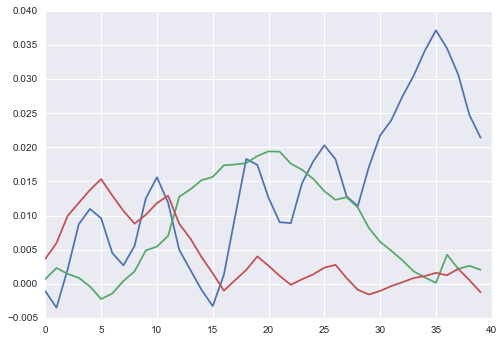

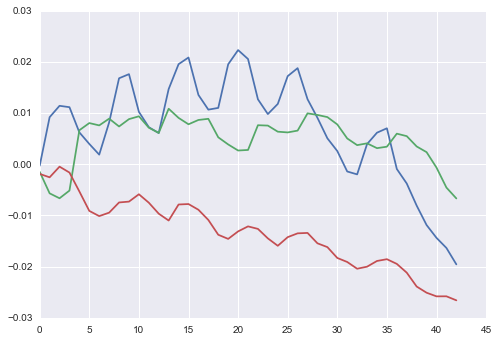

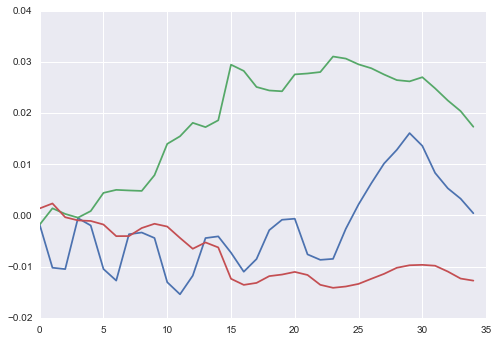

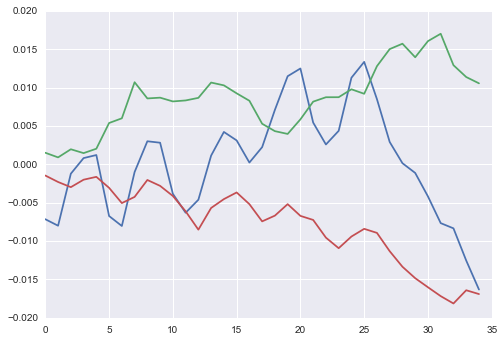

In [73]:
qr, qi, qj, qk = nine_obs_to_quaternion(dat)
plt.plot(qi); plt.plot(qj); plt.plot(qk); plt.show()

qr, qi, qj, qk = nine_obs_to_quaternion(dat2)
plt.plot(qi); plt.plot(qj); plt.plot(qk); plt.show()

qr, qi, qj, qk = nine_obs_to_quaternion(dat3)
plt.plot(qi); plt.plot(qj); plt.plot(qk); plt.show()

qr, qi, qj, qk = nine_obs_to_quaternion(dat4)
plt.plot(qi); plt.plot(qj); plt.plot(qk); plt.show()

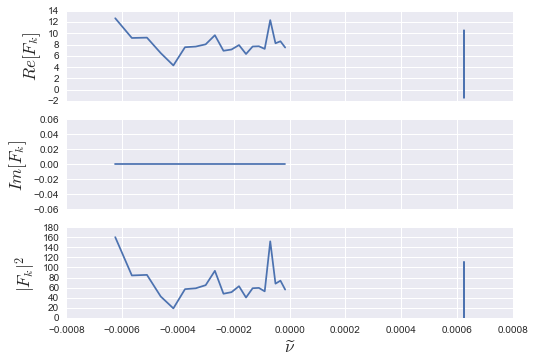

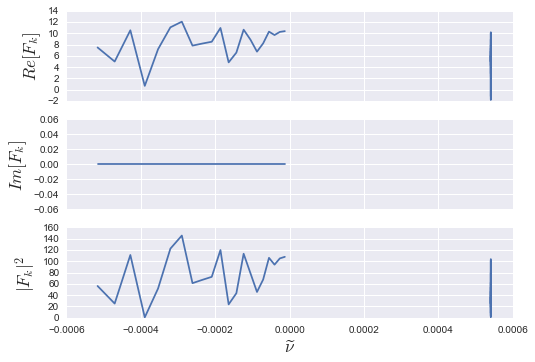

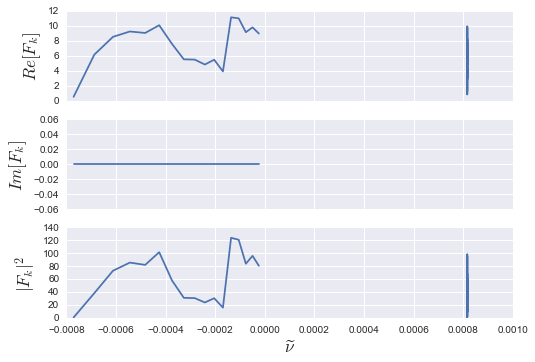

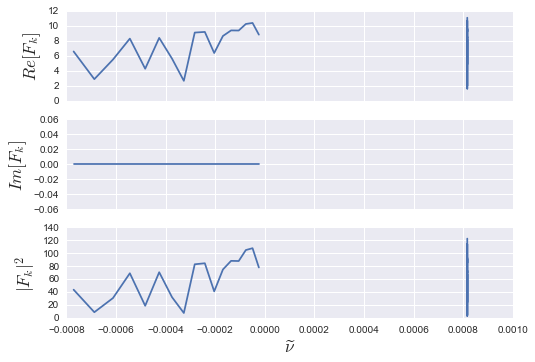

In [19]:
# FFT
from numpy import fft
def plot_FFT(dat):
    # number of data points
    n= len(dat)
    signal = dat.ix[:,2:3]

    # freq
    nu = fft.fftfreq(n, dat.time)/n
    Fk = fft.fft(signal)

    nu = fft.fftshift(nu) # Shift zero freq to center
    Fk = fft.fftshift(Fk) # Shift zero freq to center

    f, ax = plt.subplots(3,1,sharex=True)

    ax[0].plot(nu, np.real(Fk)) 
    ax[0].set_ylabel(r'$Re[F_k]$', size= 'x-large')
    ax[1].plot(nu, np.imag(Fk)) 
    ax[1].set_ylabel(r'$Im[F_k]$', size= 'x-large')
    ax[2].plot(nu, np.absolute(Fk)**2) 
    ax[2].set_ylabel(r'$\vert F_k \vert^2$', size = 'x-large')
    ax[2].set_xlabel(r'$\widetilde{\nu}$', size = 'x-large');
    #ax[3].plot(dat.time, signal)
    plt.show()
    #plt.plot(dat.time, signal); plt.show()
    
plot_FFT(dat)
plot_FFT(dat2)
plot_FFT(dat3)
plot_FFT(dat4)

In [ ]:
plt.plot(time, )

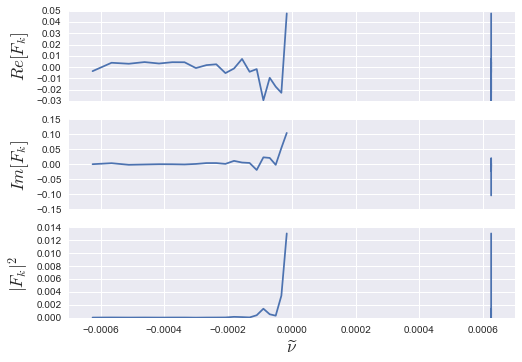

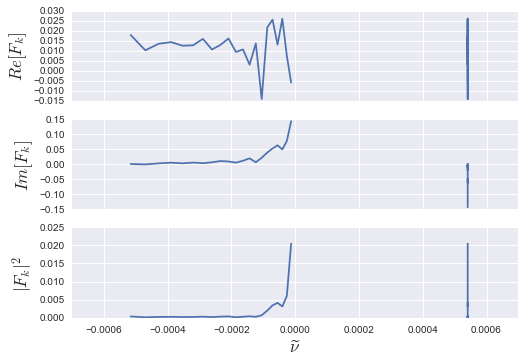

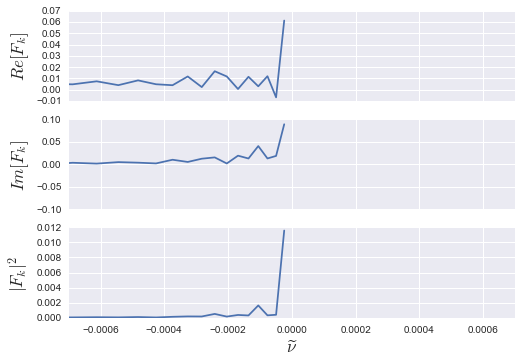

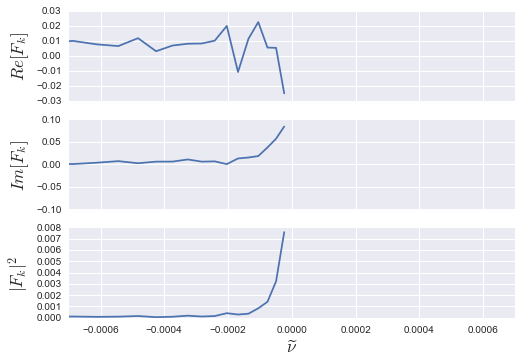

In [108]:
# FFT
from numpy import fft
def plot_FFT_q(dat):
    # number of data points
    qr, qi, qj, qk = nine_obs_to_quaternion(dat)
    n= len(qr)
    signal = qk

    # freq
    nu = fft.fftfreq(n, dat.time)/n
    Fk = fft.fft(signal)

    nu = fft.fftshift(nu) # Shift zero freq to center
    Fk = fft.fftshift(Fk) # Shift zero freq to center

    f, ax = plt.subplots(3,1,sharex=True)

    ax[0].plot(nu, np.real(Fk)) 
    ax[0].set_ylabel(r'$Re[F_k]$', size= 'x-large')
    ax[0].set_xlim([-0.0007, 0.0007])
    ax[1].plot(nu, np.imag(Fk)) 
    ax[1].set_ylabel(r'$Im[F_k]$', size= 'x-large')
    ax[2].plot(nu, np.absolute(Fk)**2) 
    ax[2].set_ylabel(r'$\vert F_k \vert^2$', size = 'x-large')
    ax[2].set_xlabel(r'$\widetilde{\nu}$', size = 'x-large');
    #ax[3].plot(dat.time, signal)
    plt.show()
    #plt.plot(dat.time, signal); plt.show()
    
plot_FFT_q(dat)
plot_FFT_q(dat2)
plot_FFT_q(dat3)
plot_FFT_q(dat4)

## original time series
<a id='raw ts'>raw ts</a>

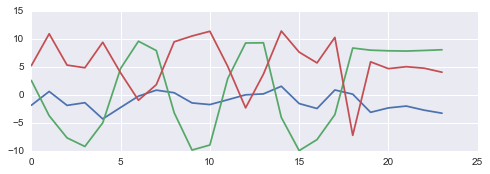

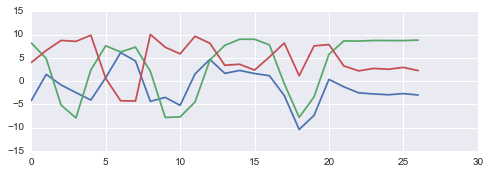

In [7]:
plt.subplot(2,1,1)
plt.plot(dat.time, dat.ax, dat.time, dat.ay, dat.time, dat.az)
plt.show()
plt.subplot(2,1,2)
plt.plot(dat2.time, dat2.ax, dat2.time, dat2.ay, dat2.time, dat2.az)
plt.show()

## overlaping four observations
<a id='ts'>overlapping</a>

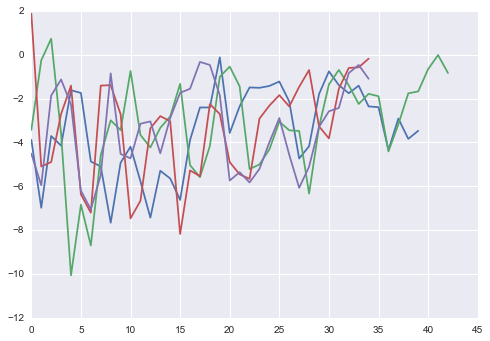

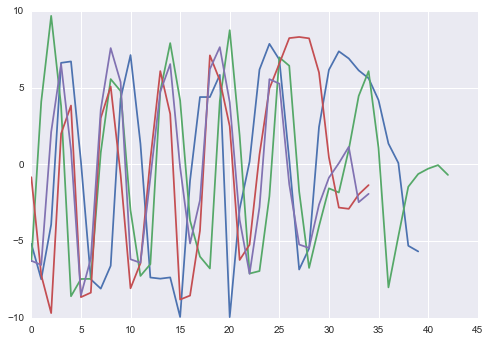

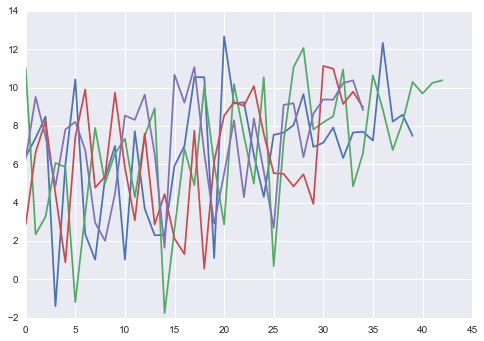

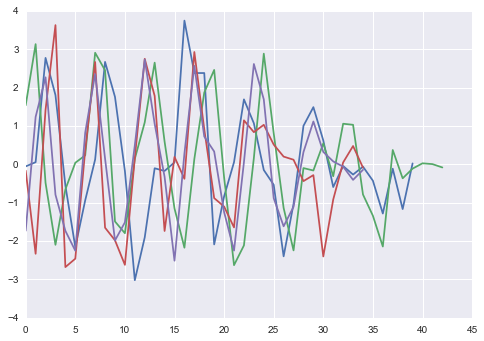

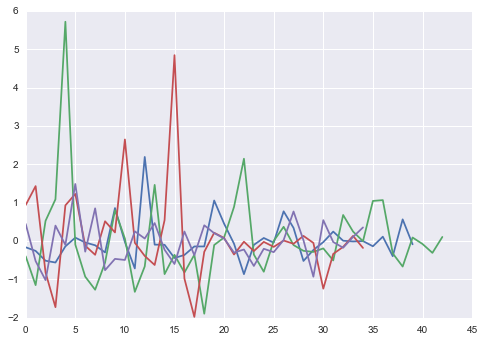

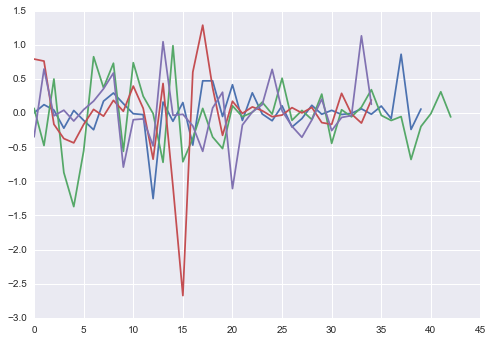

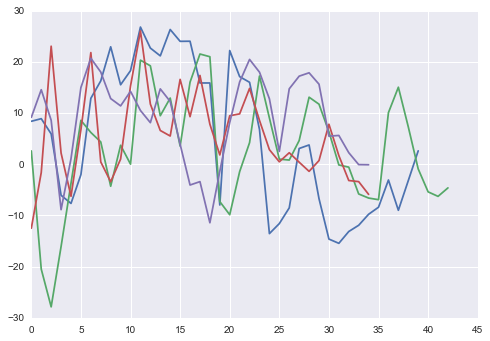

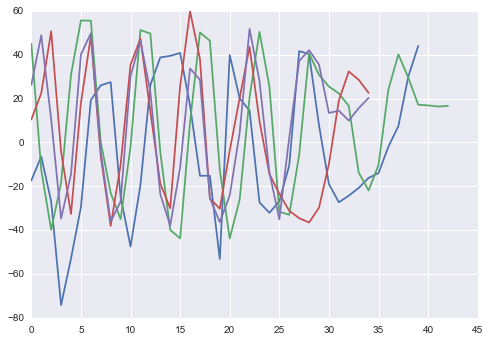

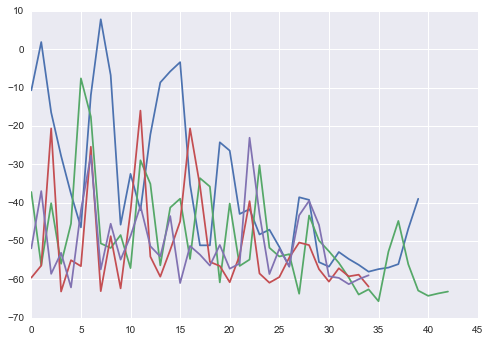

In [114]:
plt.plot(dat.time, dat.ax, dat2.time, dat2.ax, dat3.time, dat3.ax, dat4.time, dat4.ax ); plt.show()
plt.plot(dat.time, dat.ay, dat2.time, dat2.ay, dat3.time, dat3.ay, dat4.time, dat4.ay ); plt.show()
plt.plot(dat.time, dat.az, dat2.time, dat2.az, dat3.time, dat3.az, dat4.time, dat4.az ); plt.show()
plt.plot(dat.time, dat.gx, dat2.time, dat2.gx, dat3.time, dat3.gx, dat4.time, dat4.gx ); plt.show()
plt.plot(dat.time, dat.gy, dat2.time, dat2.gy, dat3.time, dat3.gy, dat4.time, dat4.gy ); plt.show()
plt.plot(dat.time, dat.gz, dat2.time, dat2.gz, dat3.time, dat3.gz, dat4.time, dat4.gz ); plt.show()
plt.plot(dat.time, dat.mx, dat2.time, dat2.mx, dat3.time, dat3.mx, dat4.time, dat4.mx ); plt.show()
plt.plot(dat.time, dat.my, dat2.time, dat2.my, dat3.time, dat3.my, dat4.time, dat4.my ); plt.show()
plt.plot(dat.time, dat.mz, dat2.time, dat2.mz, dat3.time, dat3.mz, dat4.time, dat4.mz ); plt.show()


## power spectral density approach
<a id='PSD'>PSD</a>
[Go back](#top)

In [2]:
## read data from different source 
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
sns.set(style="darkgrid")
import os 


import os
import argparse
import logging
import json
import ds_commons.s3_tools as s3
from datetime import datetime
import requests

import gzip
os.chdir('/Users/schang/Dropbox/codes/2015_TIBA/code/python')
print os.getcwd()
print os.getcwd()
true1 = pd.read_csv("../../data/seanc-bicep-1.csv", skiprows=1, sep=';')#
true2 = pd.read_csv("../../data/seanc-bicep-2.csv", skiprows=1, sep=';')
true3 = pd.read_csv("../../data/seanc-bicep-3.csv", skiprows=1, sep=';')
false1 = pd.read_csv("../../data/seanc-wbicep-1.csv", skiprows=1, sep=';')
false2 = pd.read_csv("../../data/seanc-wbicep-2.csv", skiprows=1, sep=';')
false3 = pd.read_csv("../../data/seanc-wbicep-3.csv", skiprows=1, sep=';')
false4 = pd.read_csv("../../data/seanc-wbicep-1.csv", skiprows=1, sep=';')

WARNING  LOGGER was not a defined env var.  Assuming LOGGER=tty  


/Users/schang/Dropbox/codes/2015_TIBA/code/python
/Users/schang/Dropbox/codes/2015_TIBA/code/python


accel-y


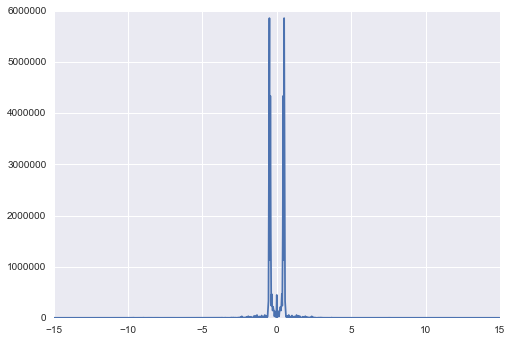

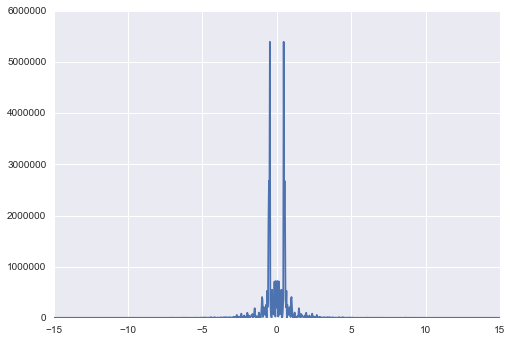

In [10]:
sensor = 'accel-y'
print sensor 

dat = true1
def plot_ps(dat):
    ps = np.abs(np.fft.fft(dat[sensor]))**2
    timestep = 1./30
    #time_step = float(dat.timestamps[-2] - dat(timestamps[0]) / float(1000)
    freqs = np.fft.fftfreq(len(dat), timestep)
    idx = np.argsort(freqs)
    plt.plot(freqs[idx], ps[idx]); plt.show()


plot_ps(true1)
plot_ps(false1)





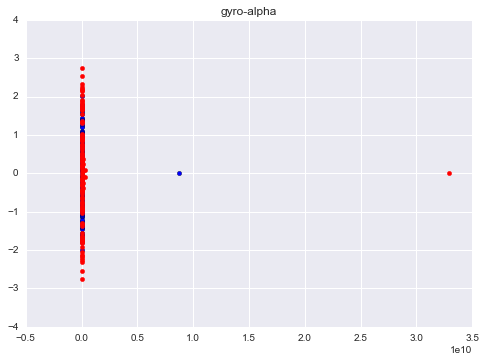

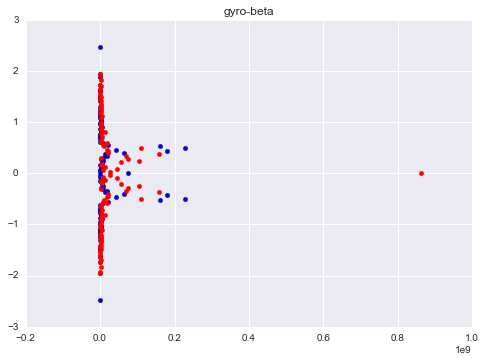

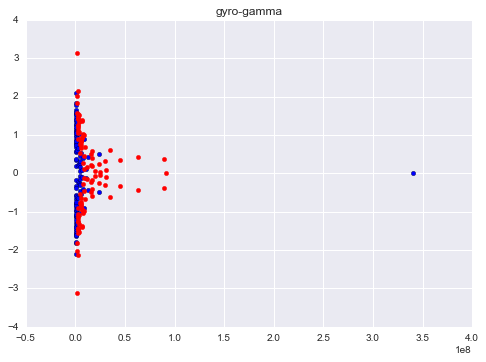

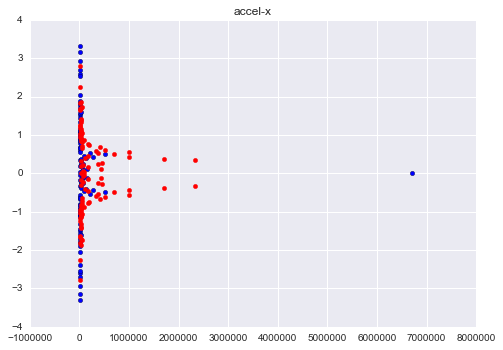

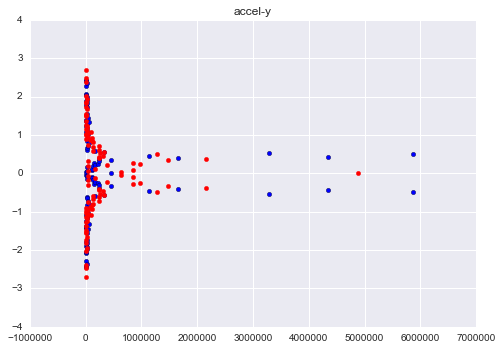

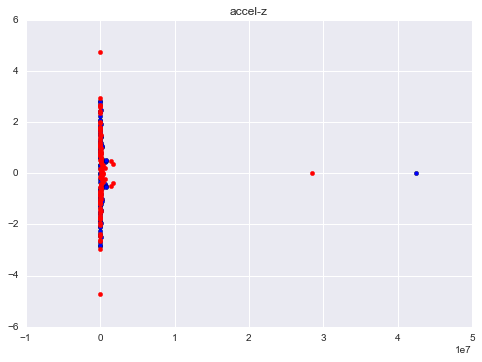

In [188]:
dat_true = true1
dat_false = false2

def gain_top_freq_val(dat):
    # i.e. get features
    ps = np.abs(np.fft.fft(dat[sensor]))**2
    timestep = 1./30
    #time_step = float(dat.timestamps[-2] - dat(timestamps[0]) / float(1000)
    freqs = np.fft.fftfreq(len(dat), timestep)
    idx = np.argsort(freqs)
    ps, freqs = ps[idx], freqs[idx]
    res = sorted(zip(ps, freqs), key=lambda x: x[0])[-100:]
    return res

sensors = false1.columns[1:]
for sensor in sensors:
    res1= gain_top_freq_val(dat_true)
    res2= gain_top_freq_val(dat_false)

    # plot top freq & magntitute 
    plt.scatter([x[0] for x in res1], [x[1] for x in res1])
    plt.scatter([x[0] for x in res2], [x[1] for x in res2], color='red')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(sensor)
    plt.show()

['accel-z']
true1
1.73042736906
0.459704825127
64.521101127
6.0609002351
10.1522154199
true2
1.73042736906
0.773637824907
47.597080912
2.28475424664
4.32918403656
false1
34.5311501333
28.7317755014
64.521101127
47.597080912
56.8892008869
false2
34.5311501333
1.14687062479
6.0609002351
47.597080912
4.01735374958
false3
28.7317755014
1.14687062479
10.1522154199
4.32918403656
6.95658622509


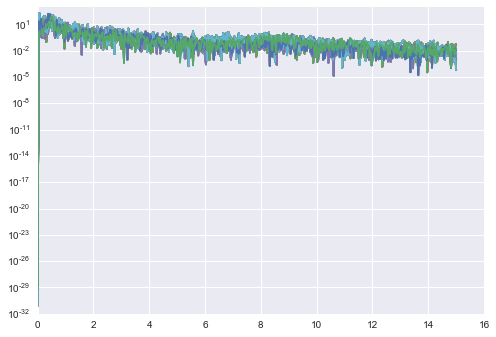

In [151]:
# PWD 2nd approach
from scipy.interpolate import interp1d
from scipy.signal import periodogram

sensors = (dat1.columns).drop('timestamp')
sensors = ['accel-z']
print sensors
sensor = 'accel-z'
dat1 = false1
dat2 = false3

def total_dist(dat1, dat2):
    total = 0 
    for sensor in sensors:

        freq1, psd1 = periodogram(dat1[sensor], 30)
        plt.semilogy(freq1, psd1)

        freq2, psd2 = periodogram(dat2[sensor], 30)
        plt.semilogy(freq2, psd2)

        #compute distance
        init = max(freq1[0], freq2[0])#max(min(freq1), min(freq2))
        end = min(freq1[-1], freq2[-1])#min(max(freq1), max(freq2))

        freq_overlapped = np.arange( init, end, (end-init)/300)
        fit1 = interp1d(freq1, psd1)
        fit2 = interp1d(freq2, psd2)

        #fit:

        dd = 10
        dist = np.mean(( np.convolve(fit1(freq_overlapped), np.ones(dd)/dd) -\
                         np.convolve(fit2(freq_overlapped), np.ones(dd)/dd))**2)
        total += dist
    print total
    
print 'true1'
total_dist(true1, true2)
total_dist(true1, true3)
total_dist(true1, false1)
total_dist(true1, false2)
total_dist(true1, false3)

print 'true2'
total_dist(true2, true1)
total_dist(true2, true3)
total_dist(true2, false1)
total_dist(true2, false2)
total_dist(true2, false3)

print 'false1'
total_dist(false1, false2)
total_dist(false1, false3)
total_dist(false1, true1)
total_dist(false1, true2)
total_dist(false1, true3)

print 'false2'
total_dist(false2, false1)
total_dist(false2, false3)
total_dist(false2, true1)
total_dist(false1, true2)
total_dist(false2, true3)

print 'false3'
total_dist(false3, false1)
total_dist(false3, false2)
total_dist(false3, true1)
total_dist(false3, true2)
total_dist(false3, true3)




In [152]:
# adapt this method to the straming data
sensor = 'accel-z'
samples = [true3[sensor], false4[sensor]]

from scipy.interpolate import interp1d
from scipy.signal import periodogram

f1, p1 = periodogram(true1[sensor], 30)
f2, p2 = periodogram(true2[sensor], 30)
f3, p3 = periodogram(false1[sensor], 30)
f4, p4 = periodogram(false2[sensor], 30)
f5, p5 = periodogram(false3[sensor], 30)
freq_all = [f1, f2, f3, f4, f5]
psd_all = [p1, p2, p3, p4, p5]


def dist(freq1, psd1, freq2, psd2):        #compute distance
    
    init = max(freq1[0], freq2[0])#max(min(freq1), min(freq2))
    end = min(freq1[-1], freq2[-1])#min(max(freq1), max(freq2))
    freq_overlapped = np.arange( init, end, (end-init)/300)
    
    fit1 = interp1d(freq1, psd1)
    fit2 = interp1d(freq2, psd2)

    #fit:
    dd = 10
    dist = np.mean(( np.convolve(fit1(freq_overlapped), np.ones(dd)/dd) -\
                     np.convolve(fit2(freq_overlapped), np.ones(dd)/dd))**2)
    return dist

def classifier(samples):
    res = []
    dist_all = {}
    for sample in samples:
        freq_sample, psd_sample = periodogram(sample, 30)
        for i in range(len(freq_all)):
            dist_all[dist(freq_sample, psd_sample, freq_all[i], psd_all[i])] = i
        print dist_all
        if dist_all[np.min(dist_all.keys())] <= 1:
            res.append(0)
        else:
            res.append(1)
    print res
    return res

classifier(samples)

{4.0173537495835649: 3, 0.77363782490650201: 1, 6.9565862250948474: 4, 0.45970482512693012: 0, 56.889200886911993: 2}
{0.0: 2, 64.521101126968688: 0, 0.45970482512693012: 0, 34.531150133291568: 3, 28.731775501391382: 4, 0.77363782490650201: 1, 56.889200886911993: 2, 4.0173537495835649: 3, 6.9565862250948474: 4, 47.597080912025035: 1}
[0, 1]


[0, 1]

In [120]:
df = (dat.columns).drop('timestamp')
#df.drop('timestamp')

In [192]:
dat_all = [true1, true2, false1, false2, false3]
label = ['t', 't', 'f', 'f', 'f']
samples = []
labels = []
count = 0

sensor = "accel-y"
for dat in dat_all:
    len_sample = 100
    idx = range(0,  len(dat), len_sample)
    for i in range(len(idx)-1):
        samples.append(gain_top_freq_val(dat))
        labels.append(label[count])
    count += 1

In [193]:
from sklearn import svm
clf = svm.SVC(kernel="rbf", C= 0.025)
clf.fit(samples, labels)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [126]:
# original idea

dat_all = [true1, true2, false1, false2, false3]
label = ['t', 't', 'f', 'f', 'f']
samples = []
labels = []
count = 0

for dat in dat_all:
    len_sample = 100
    idx = range(0,  len(dat), len_sample)
    for i in range(len(idx)-1):
        #samples.append(list(dat[sensor][idx[i]: idx[i+1]]))
        samples.append(list(np.fft.fft(dat[sensor][idx[i]: idx[i+1]])))
        labels.append(label[count])
    count += 1

In [109]:
from sklearn import svm
clf = svm.SVC(kernel="rbf", C= 0.025)
clf.fit(samples, labels)

/Users/schang/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:373: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

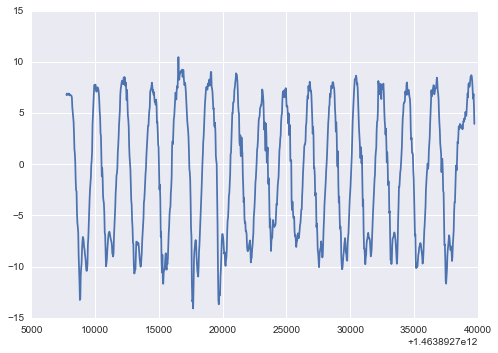

In [35]:
dat = true1#false1
time = dat.timestamp
signal = dat["accel-x"]
n = len(dat)
plt.plot(dat.timestamp, dat["accel-y"]); plt.show()
freq = fft.fftfreq(n, time)/n
transformed = fft.fft(signal)
#print freq, transformed

In [40]:
from sklearn import svm
svr = svm.SVC(kernel="rbf", C= 0.025)
sensor = "accel-y"
training = [list(true1[sensor]), list(true3[sensor])]


[[6.7884368896484375, 6.9200439453125, 6.8051910400390634, 6.8602294921875, 6.8841552734375, 6.8003997802734375, 6.9224395751953125, 6.8841552734375, 6.745361328125, 6.750152587890625, 6.762115478515625, 6.7333984375, 6.7070770263671884, 6.5228271484375, 5.5680999755859375, 5.130218505859375, 4.6133575439453125, 4.168304443359375, 3.0173492431640625, 1.5050811767578125, 1.071990966796875, 0.18902587890625, -1.5625152587890625, -2.53399658203125, -2.6488494873046875, -4.5942230224609375, -5.7212371826171884, -6.1016998291015625, -6.6951141357421884, -8.8127593994140625, -9.9948272705078125, -11.590835571289062, -13.258636474609375, -13.141387939453125, -10.87298583984375, -10.171890258789062, -9.6694030761718768, -8.3629150390625, -7.558929443359375, -7.09710693359375, -7.1928253173828125, -7.535003662109375, -8.087738037109375, -8.3078765869140625, -8.8079833984375, -9.0998992919921875, -9.5760803222656232, -10.2628173828125, -10.418350219726562, -10.34417724609375, -9.6861419677734375

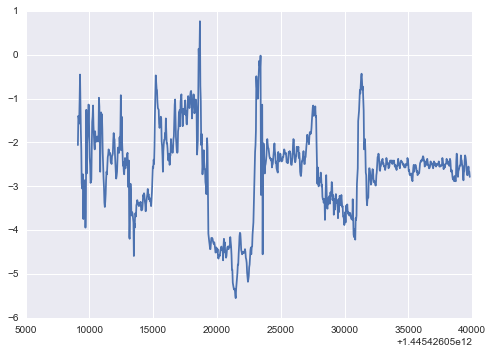

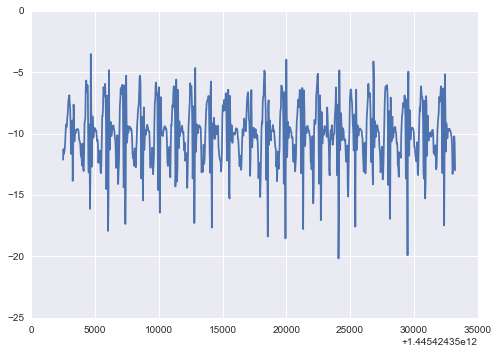

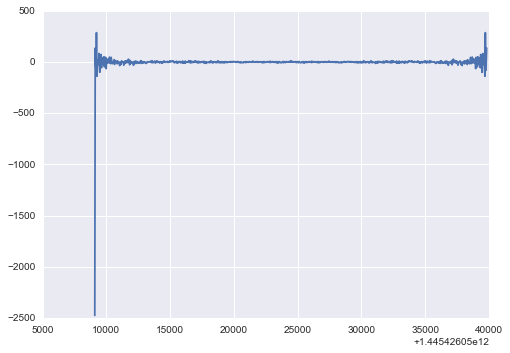

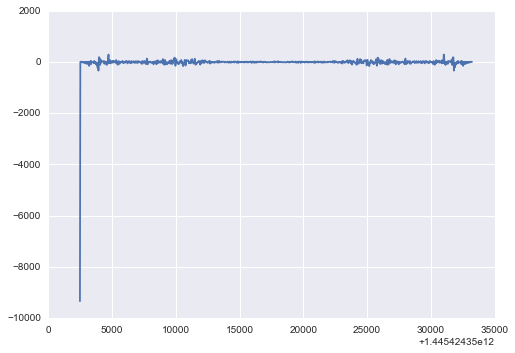

In [124]:
plt.plot(true1.timestamp, true1[sensor]); plt.show()
plt.plot(true2.timestamp, true2[sensor]); plt.show()

plt.plot(true1.timestamp, fft.fft(true1[sensor])); plt.show()
plt.plot(true2.timestamp, fft.fft(true2[sensor])); plt.show()
